-----------------------------------------------------------------------------------------------------------------------
# **Crude Oil Production Forecasting - AR, MA, ARMA, ARIMA**
-----------------------------------------------------------------------------------------------------------------------

----------------
## **Context** 
----------------

Crude oil is a foundational part of the global economy. It is used for a whole host of cases including the production of gasoline, diesel, hydrocarbon based liquids (paints, solvents, plastics), kerosene and products such as lubes, waxes and asphalt. The transportation sector is heavily dependent on crude oil. Despite the rise in renewable sources of energy, crude oil's importance accross the globe is unrivalled.

The price of crude oil fluctuates due to changes in demand, supply and other impacts on the global supply chain (e.g. the war in Russian and Ukraine). This can have detrimental impacts on a lot of sectors, as it makes planning, forecasting and financial management of entire sectors very difficult.

As such, crude oil production forecasting can be very useful in these industries.

In this workbook, we will analyze and use historical oil production data, from 1992 to 2018. We will build the following models:

- Moving Average (MA): Uses a regression like model using past forecast eror terms
- Auto-regressive model (AR): A simple model which uses past values to predict future values
- Auto-regressive moving average (ARMA): combination of AR and MA models
- Auto-regressive integrated moving average model (ARIMA): ARMA model with past terms differenced to make the time-series stationary.


--------------------------
## **Dataset**
--------------------------

This dataset contains the yearly oil production of 222 countries, but we will focus on only on the US

## **Step 1 - Importing libraries and inspect data**

In [104]:

import statsmodels
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import statsmodels.api as sm

from statsmodels.graphics import tsaplots

from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [105]:
#load dataset
data = pd.read_csv('/Users/guransingh/Library/CloudStorage/OneDrive-Personal/Documents/Work/Python Notebooks/Python Notebooks/MIT/Oil_TimeSeries/Crude+Oil+Production+by+Country.csv')

data.head()

,Country,1992,1993,1994,1995,1996,1997,1998,1999,2000,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,United States,7171,6847,6662,6560,6465,6451,6252,5881,5822,...,5349,5478,5654,6502.0,7467.0,8759.0,9431.0,8831.0,9352.0,10962.0
1,Saudi Arabia,8332,8198,8120,8231,8218,8362,8389,7833,8404,...,8250,8900,9458,9832.0,9693.0,9735.0,10168.0,10461.0,10134.0,10425.0
2,Russia,7632,6730,6135,5995,5850,5920,5854,6079,6479,...,9495,9694,9774,9922.0,10054.0,10107.0,10253.0,10551.0,10580.0,10759.0
3,Canada,1605,1679,1746,1805,1837,1922,1981,1907,1977,...,2579,2741,2901,3138.0,3325.0,3613.0,3677.0,3679.0,3977.0,4264.0
4,Iraq,425,512,553,560,579,1155,2150,2508,2571,...,2391,2399,2626,2983.0,3054.0,3368.0,4045.0,4444.0,4454.0,4613.0


In [106]:
#inspect data shape
data.shape

(223, 28)

In [107]:
# Since we only want to use US data, lets make a dataset with it
united_states = data.loc[0]


# Dropping the variable country, as we only need the time and production information to build the model
united_states = pd.DataFrame(united_states).drop(['Country'])

# Fetching the two columns - YEAR and OIL PRODUCTION
united_states = united_states.reset_index()


united_states.columns = ['YEAR', 'OIL PRODUCTION']


# Converting the data type for variable OIL PRODUCTION to integer
united_states['OIL PRODUCTION'] = united_states['OIL PRODUCTION'].astype(int)

# Converting the YEAR column data type to datetime
united_states['YEAR'] = pd.to_datetime(united_states['YEAR'])

# Setting the variable YEAR as the index of this dataframe
united_states = united_states.set_index('YEAR')

# Checking the time series crude oil production data for United States
united_states.head()

,OIL PRODUCTION
YEAR,
1992-01-01,7171
1993-01-01,6847
1994-01-01,6662
1995-01-01,6560
1996-01-01,6465


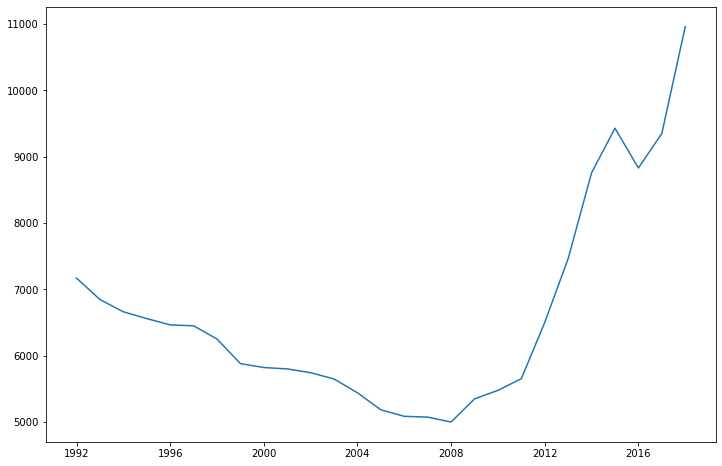

In [108]:
plt.figure(figsize = (12, 8))
plt.plot(united_states)

- The above plot shows that the oil production of United States was declining from the early 1990s to the mid 2000s but has been increasing almost constantly since then.

## Step 2 - Decomposing The Time Series


Let's now decompose the above time series into its various components, 'trend', 'seasonality' and 'white noise'

In [109]:
# Using seasonal_decompose function to decompose the time series into its individual components
decomposition = sm.tsa.seasonal_decompose(united_states)

In [110]:
# Creating an empty dataframe to store the individual components
decomposed_data = pd.DataFrame()

# Extracting the trend component of time series
decomposed_data['trend'] = decomposition.trend

# Extracting the seasonal component of time series
decomposed_data['seasonal'] = decomposition.seasonal

# Extracting the white noise or residual component of time series
decomposed_data['random_noise'] = decomposition.resid

Plotting the above three components in a single plot

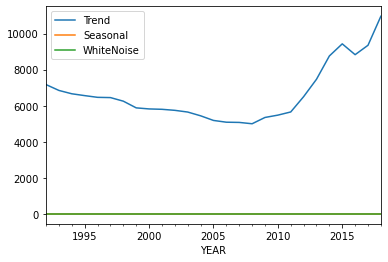

In [111]:
decomposed_data.trend.plot(label='Trend')
decomposed_data.seasonal.plot(label='Seasonal')
decomposed_data.random_noise.plot(label='WhiteNoise')

plt.legend()

There is a trend component in the data, but there are no seasonality or white noise components

## Step 3 - Train/Test Split

In [112]:
# Use the first 20 years data as the training data
train_data = united_states.loc['1992-01-01' : '2012-01-01']

# Using the last 7 years data as the test data
test_data = united_states.loc['2012-01-01':]

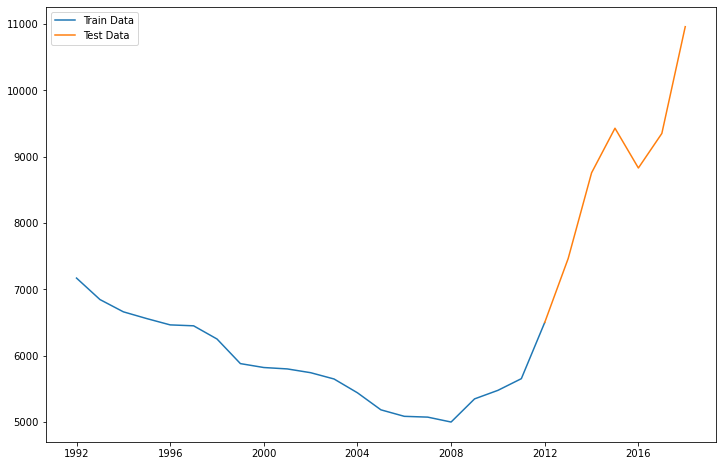

In [113]:
#now lets plot the train and test data
plt.figure(figsize = (12,8))
plt.plot(train_data,label='Train Data')
plt.plot(test_data, label='Test Data')
plt.legend()

## Step 4 - Checking for stationarity

Checking for stationary is an import part of timeseries forecasting. The time series is stationary if its statistical behavior remains constant throughout. Stationary timeseries are easier to understand and predict, it is equivalent to a linear model. Most models (e.g. AR) assume the time series is stationary.

If the time series is not stationary, we can difference the terms to make it stationary ('I' value in the ARIMA model)

Before building a time series model, we need to make sure that the time series is stationary. If the time series is non-stationary, then we need to make it stationary by differencing the data. The number of times we take a difference of the data is a parameter used in ARIMA models, which we will see shortly.

Lets use the Augumented Dicky Fuller Test

In [114]:
# Importing ADF test from statsmodels package
from statsmodels.tsa.stattools import adfuller

# Implementing ADF test on the original time series data
result = adfuller(train_data['OIL PRODUCTION'])

# Printing the results
print(result[0])

print(result[1]) # To get the p-value

print(result[4])

-0.5829098523091646
0.8747971281795595
{'1%': -4.01203360058309, '5%': -3.1041838775510207, '10%': -2.6909873469387753}


the p-value is very high. So we cannot reject the null hypothese that the time series is non-stationary

<AxesSubplot:xlabel='YEAR'>

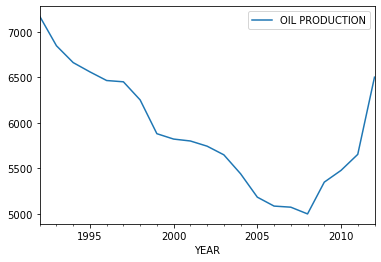

In [115]:
#lets also plot the training data again
train_data.plot()

Lets subtract the difference once (d=1). We keep subtracting until the time series becomes stationary

ADF Statistic: 1.5758007070601794
p-value: 0.9977831288888283


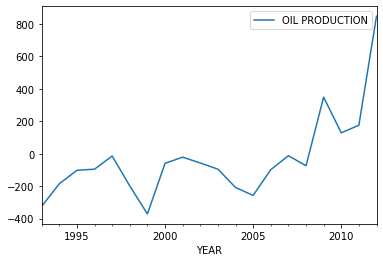

In [116]:
# Taking the 1st order differencing of the timeseries
train_data_stationary = train_data.diff().dropna()

# Implementing ADF test on the first order differenced time series data
result = adfuller(train_data_stationary['OIL PRODUCTION'])

train_data_stationary.plot()


print('ADF Statistic:', result[0])

print('p-value:', result[1])

p-value is still very high (0.99), so we continue differencing

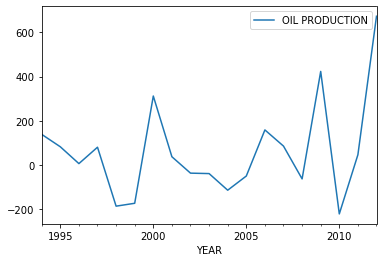

ADF Statistic: -1.5580506601256108
p-value: 0.5046243689112169


In [117]:
# Taking the 2nd order differencing of the time series
train_data_stationary = train_data.diff().diff().dropna()

# Implementing ADF test on the second order differenced time series data
result = adfuller(train_data_stationary['OIL PRODUCTION'])


train_data_stationary.plot()

plt.show()


print('ADF Statistic:', result[0])

print('p-value:', result[1])

Here p value is still very high, but its getting smaller. Lets difference again (d=3)

ADF Statistic: -6.191607528895947
p-value: 6.103650224876215e-08


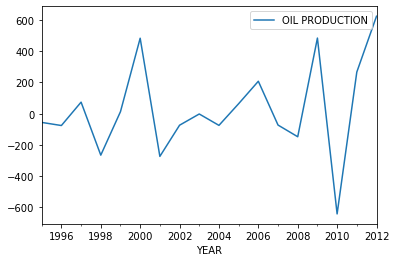

In [118]:
# Taking the 3rd order differencing of the time series
train_data_stationary = train_data.diff().diff().diff().dropna()

# Implementing ADF test on the second order differenced time series data
result = adfuller(train_data_stationary['OIL PRODUCTION'])

train_data_stationary.plot()

print('ADF Statistic:', result[0])

print('p-value:', result[1])

Now the p value is less than 0.05. So we can conclude that the time series is now stationary. Since we took the difference 3 times, the parameter d in ARIMA models is d = 3

## Step 5 - ACF and PACF Plots

These help find the p and q parameters. ACF helps find q, the MA parameter. PACF helps find p the AR parameter. We already know d = 3

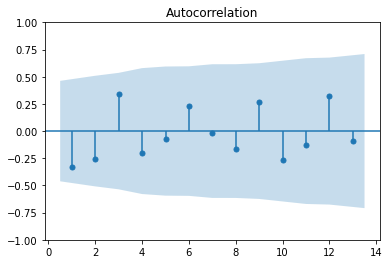

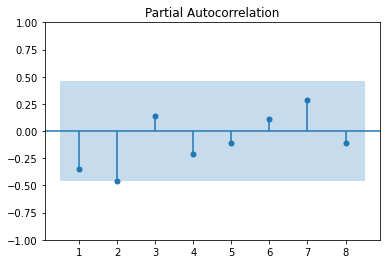

In [119]:
# Creating and plotting the ACF charts starting from lag = 1
tsaplots.plot_acf(train_data_stationary, zero = False)

# Creating and plotting the PACF charts starting from lag = 1 till lag = 8
tsaplots.plot_pacf(train_data_stationary, zero = False,lags = 8)

plt.show()

From the above plots, it does not look like this stationary time series follows a pure AR or MA model. So lets test all of them

- AR (p)
- MA (q)
- ARMA (p, q)
- ARIMA (p, d, q)

and then we will check which one performs better.

## Step 6 - AR Model

In [120]:
# Since we are building an AR model using ARIMA function, we have to keep the q = 0 (MA parameter). ALso have to use the stationary time series which we discovered.


#Lets create AR 1, 2,3,4 models
ar_1_model = ARIMA(train_data_stationary, order = (1, 0, 0))
ar_2_model = ARIMA(train_data_stationary, order = (2, 0, 0))
ar_3_model = ARIMA(train_data_stationary, order = (3, 0, 0))
ar_4_model = ARIMA(train_data_stationary, order = (4, 0, 0))

In [121]:
# Fit all models
ar_1_results = ar_1_model.fit()

ar_2_results = ar_2_model.fit()

ar_3_results = ar_3_model.fit()

ar_4_results = ar_4_model.fit()

As we differenced 3 times, the forecasted results will also be of the same scale. So we have to 'transform' them to the original scale but take cumulative sums multiple times

In [122]:
# We are taking double cumulative sum of forecasted values (which is inverse of double differencing)
    # And we are also adding the last element of the training data to the forecasted values to get back to the original scale
def plot_predicted_output(results):
    predictions = np.cumsum(np.cumsum(results.predict(start = 19, end = 25))) + train_data.iloc[-1][0]
    predictions.index = test_data.index
    print('AIC is '+str(results.aic))
    print('MSE is '+str(mean_squared_error(test_data,predictions)))
    plt.plot(train_data,label='Train data')
    plt.plot(test_data,label='Test data')
    plt.plot(predictions,label='Forecasted data')
    plt.legend()
    plt.show()

AIC is 259.3822719994876
MSE is 3988770.9489912903


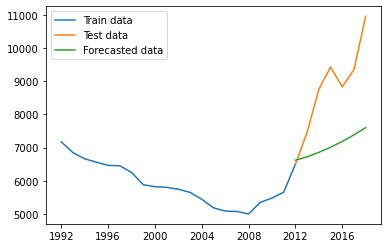

AIC is 251.66139015717326
MSE is 1844261.243859638


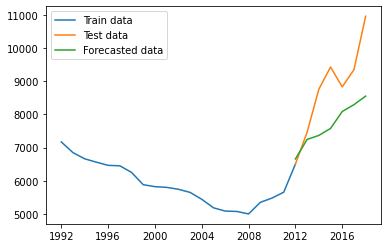

AIC is 253.64398388672805
MSE is 1773090.4040234846


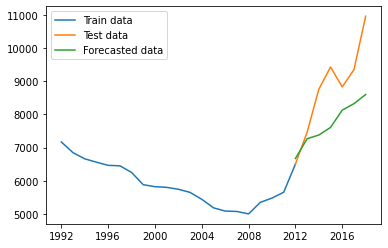

AIC is 252.99025230646194
MSE is 1509434.8607223039


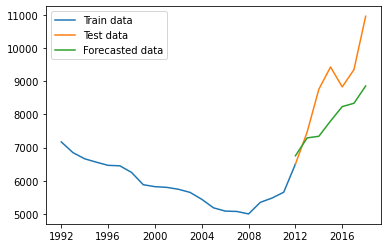

In [123]:
# Plotting the forecasted values along with train and test for all the models

#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 10))

plot_predicted_output(ar_1_results)

plot_predicted_output(ar_2_results)

plot_predicted_output(ar_3_results)

plot_predicted_output(ar_4_results)

As you can see, AR(4) model gives the lowest MSE and this is also confirmed visually from the green line. The AIC modfels for all models is close. AIC penalizes overly complicated models.

In [124]:
#Lets check the summary of AR(4)
ar_4_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         OIL PRODUCTION   No. Observations:                   18
Model:                 ARIMA(4, 0, 0)   Log Likelihood                -120.495
Date:                Thu, 29 Dec 2022   AIC                            252.990
Time:                        15:43:51   BIC                            258.332
Sample:                    01-01-1995   HQIC                           253.727
                         - 01-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.0306     17.221      0.466      0.641     -25.722      41.783
ar.L1         -0.8563      0.371     -2.308      0.021      -1.583      -0.129
ar.L2         -1.0208      0.534     -1.911      0.056      -2.067       0.026
ar.L3         -0.3271      0.410     -0.799      0.425      -1.130       0.476
ar.L4         -0.4350      0.340     -1.280      0.201      -1.101       0.231
sigma2      3.249e+04   2.03e+04      1.600      0.110   -7311.525    7.23e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.57   Jarque-Bera (JB):                 0.37
Prob(Q):                              0.45   Prob(JB):                         0.83
Heteroskedasticity (H):               2.22   Skew:                             0.10
Prob(H) (two-sided):                  0.36   Kurtosis:                         2.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Step 7 - MA Model

In [125]:
# Since this is an MA model, p = 0. We also need to pass the stationary data series

ma_1_model = ARIMA(train_data_stationary, order = (0, 0, 1))

ma_2_model = ARIMA(train_data_stationary, order = (0, 0, 2))

ma_3_model = ARIMA(train_data_stationary, order = (0, 0, 3))

ma_4_model = ARIMA(train_data_stationary, order = (0, 0, 4))

In [126]:
# fit all the models

ma_1_results = ma_1_model.fit()

ma_2_results = ma_2_model.fit()

ma_3_results = ma_3_model.fit()

ma_4_results = ma_4_model.fit()

AIC is 252.60420026344013
MSE is 6101658.178657451


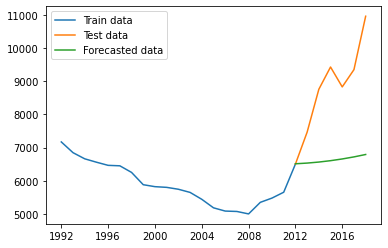

AIC is 252.72007601398536
MSE is 843799.1039269122


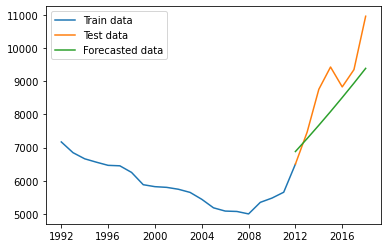

AIC is 250.7946028582071
MSE is 2794470.2146593085


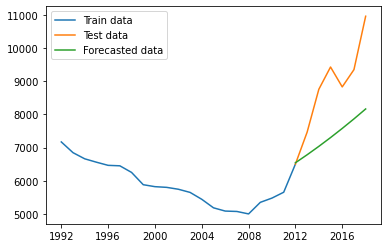

AIC is 250.87442541970566
MSE is 1960018.057616856


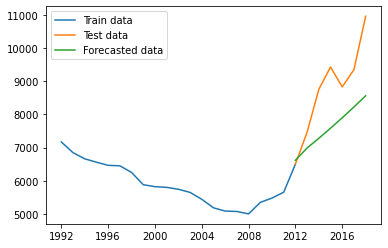

In [127]:
#plot all the results

plot_predicted_output(ma_1_results)

plot_predicted_output(ma_2_results)

plot_predicted_output(ma_3_results)

plot_predicted_output(ma_4_results)

MA(2) has the lowest MSE. This is also confirmed visually via the green line

In [128]:
#Lets check the summary of MA(2)
ma_2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         OIL PRODUCTION   No. Observations:                   18
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -122.360
Date:                Thu, 29 Dec 2022   AIC                            252.720
Time:                        15:43:52   BIC                            256.282
Sample:                    01-01-1995   HQIC                           253.211
                         - 01-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.9264     12.360      0.884      0.377     -13.298      35.151
ma.L1         -1.7155     21.302     -0.081      0.936     -43.467      40.036
ma.L2          0.9964     24.680      0.040      0.968     -47.375      49.368
sigma2       3.39e+04   8.22e+05      0.041      0.967   -1.58e+06    1.64e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):                 0.84
Prob(Q):                              0.54   Prob(JB):                         0.66
Heteroskedasticity (H):               1.59   Skew:                             0.51
Prob(H) (two-sided):                  0.59   Kurtosis:                         3.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Step 7 - ARMA Modeling

In [129]:
# In ARMA model, we need both p and q. We will pass the stationary data series. Lets try a few different combinations of p and q

ar_2_ma_1_model = ARIMA(train_data_stationary, order = (2, 0, 1))

ar_2_ma_2_model = ARIMA(train_data_stationary, order=(2, 0, 2))

ar_3_ma_2_model = ARIMA(train_data_stationary, order = (3, 0, 2))

ar_2_ma_3_model = ARIMA(train_data_stationary, order = (2, 0, 3))

In [130]:
# Fitting all the models that we implemented in the above cell

ar_2_ma_1_results = ar_2_ma_1_model.fit()

ar_2_ma_2_results = ar_2_ma_2_model.fit()

ar_3_ma_2_results = ar_3_ma_2_model.fit()

ar_2_ma_3_results = ar_2_ma_3_model.fit()

AIC is 254.19892869234238
MSE is 779417.4637577345


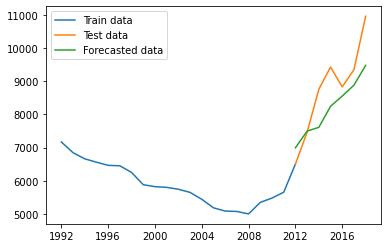

AIC is 250.42045856234319
MSE is 946149.0070627079


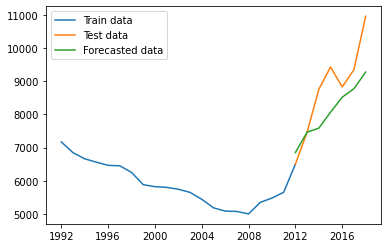

AIC is 252.42119365505764
MSE is 942800.2318036521


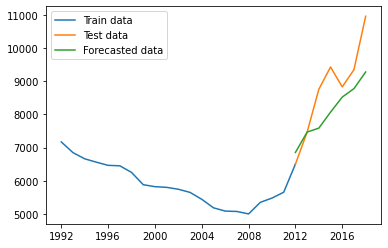

AIC is 252.77331568416776
MSE is 1700198.710251968


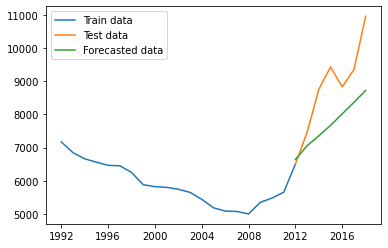

In [131]:
# Plot the data

plot_predicted_output(ar_2_ma_1_results)

plot_predicted_output(ar_2_ma_2_results)

plot_predicted_output(ar_3_ma_2_results)

plot_predicted_output(ar_2_ma_3_results)

AR2MA1 model is has the lowest MSE. It is also confimed visually via the green line

In [132]:
#Lets check the summary
ar_2_ma_1_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         OIL PRODUCTION   No. Observations:                   18
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -122.099
Date:                Thu, 29 Dec 2022   AIC                            254.199
Time:                        15:43:52   BIC                            258.651
Sample:                    01-01-1995   HQIC                           254.813
                         - 01-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.7024     35.053      0.248      0.804     -60.001      77.405
ar.L1         -1.2900      0.177     -7.274      0.000      -1.638      -0.942
ar.L2         -0.8182      0.249     -3.288      0.001      -1.306      -0.330
ma.L1          0.9835      2.287      0.430      0.667      -3.498       5.465
sigma2      3.583e+04   7.52e+04      0.477      0.634   -1.12e+05    1.83e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.47   Jarque-Bera (JB):                 0.37
Prob(Q):                              0.23   Prob(JB):                         0.83
Heteroskedasticity (H):               1.75   Skew:                             0.12
Prob(H) (two-sided):                  0.51   Kurtosis:                         2.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Step 8 - ARIMA Model

Since we are using ARIMA model, the model can handle the differencing itself via the d parameter. We calculated d to be 3 earlier. So we do not need to pass the stationary series, we can use the original training data here

In [133]:
train_data = train_data.astype('float32')

In [134]:
ar_2_d_3_ma_1_model = ARIMA(train_data, order = (2, 3, 1))

ar_1_d_3_ma_2_model = ARIMA(train_data, order = (1, 3, 2))

ar_2_d_3_ma_2_model = ARIMA(train_data, order = (2, 3, 2))

ar_3_d_3_ma_2_model = ARIMA(train_data, order = (3, 3, 2))

In [135]:
# Fit all the models
ar_2_d_3_ma_1_results = ar_2_d_3_ma_1_model.fit()

ar_1_d_3_ma_2_results = ar_1_d_3_ma_2_model.fit()

ar_2_d_3_ma_2_results = ar_2_d_3_ma_2_model.fit()

ar_3_d_3_ma_2_results = ar_3_d_3_ma_2_model.fit()

Since we don't use a differenced series, we don't need to trasnform the predictions. So first, lets fix the plot function defined above by removing that 

In [136]:
def plot_predicted_output_new(results):
    
    predictions = results.predict(start = 19, end = 25)
    
    predictions.index = test_data.index
    
    print('AIC is '+str(results.aic))
    print('MSE is '+str(mean_squared_error(test_data,predictions)))
    plt.plot(train_data,label='Train data')
    plt.plot(test_data,label='Test data')
    plt.plot(predictions,label='Forecasted data')
    plt.legend()
    plt.show()

AIC is 252.22716157902724
MSE is 1236478.8177979034


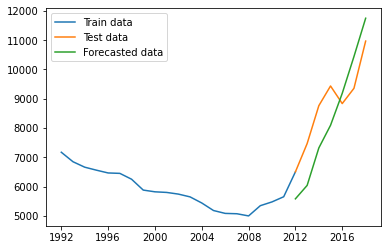

AIC is 253.41322572283758
MSE is 1707010.259342557


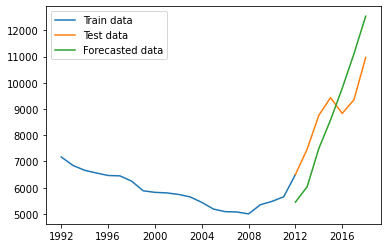

AIC is 251.42678420253995
MSE is 1130663.488638884


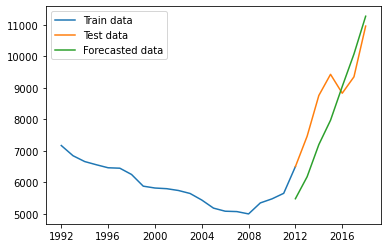

AIC is 253.34219492493182
MSE is 1136337.6503921382


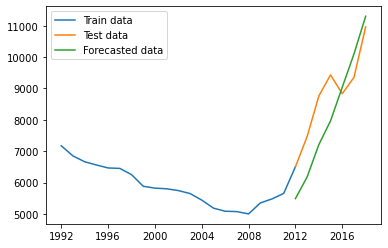

In [137]:
# Plot the results

plot_predicted_output_new(ar_2_d_3_ma_1_results)

plot_predicted_output_new(ar_1_d_3_ma_2_results)

plot_predicted_output_new(ar_2_d_3_ma_2_results)

plot_predicted_output_new(ar_3_d_3_ma_2_results)

ARIMA (2,3,2) seems like the best model

In [138]:
#Lets check the summary
ar_2_d_3_ma_2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         OIL PRODUCTION   No. Observations:                   21
Model:                 ARIMA(2, 3, 2)   Log Likelihood                -120.713
Date:                Thu, 29 Dec 2022   AIC                            251.427
Time:                        15:43:53   BIC                            255.879
Sample:                    01-01-1992   HQIC                           252.041
                         - 01-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9701      0.276     -3.518      0.000      -1.511      -0.430
ar.L2         -0.5351      0.318     -1.685      0.092      -1.158       0.087
ma.L1          0.2168      7.403      0.029      0.977     -14.293      14.726
ma.L2         -0.7778      6.047     -0.129      0.898     -12.630      11.074
sigma2      2.577e+04   1.97e+05      0.131      0.896   -3.61e+05    4.12e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.67   Jarque-Bera (JB):                 0.91
Prob(Q):                              0.41   Prob(JB):                         0.64
Heteroskedasticity (H):               1.85   Skew:                            -0.10
Prob(H) (two-sided):                  0.47   Kurtosis:                         1.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""